# medical background of Pneumonia
Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

----

![https://d2jx2rerrg6sh3.cloudfront.net/image-handler/ts/20201218062244/ri/850/picture/2020/12/Capture27.jpg](https://d2jx2rerrg6sh3.cloudfront.net/image-handler/ts/20201218062244/ri/850/picture/2020/12/Capture27.jpg)

----

## about the dataset
In this competition, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

Here’s the backstory and why solving this problem matters.

Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments [1] and over 50,000 deaths in 2015 [2], keeping the ailment on the list of top 10 causes of death in the country.

While common, accurately diagnosing pneumonia is a tall order. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity [3] on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR [4], complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.

To improve the efficiency and reach of diagnostic services, the Radiological Society of North America (RSNA®) has reached out to Kaggle’s machine learning community and collaborated with the US National Institutes of Health, The Society of Thoracic Radiology, and MD.ai to develop a rich dataset for this challenge.

The RSNA is an international society of radiologists, medical physicists and other medical professionals with more than 54,000 members from 146 countries across the globe. They see the potential for ML to automate initial detection (imaging screening) of potential pneumonia cases in order to prioritize and expedite their review.

Challenge participants may be invited to present their AI models and methodologies during an award ceremony at the RSNA Annual Meeting which will be held in Chicago, Illinois, USA, from November 25-30, 2018.

### References
Rui P, Kang K. National Ambulatory Medical Care Survey: 2015 Emergency Department Summary Tables. Table 27. Available from: www.cdc.gov/nchs/data/nhamcs/web_tables/2015_ed_web_tables.pdf

Deaths: Final Data for 2015. Supplemental Tables. Tables I-21, I-22. Available from: www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_06_tables.pdf

Franquet T. Imaging of community-acquired pneumonia. J Thorac Imaging 2018 (epub ahead of print). PMID 30036297

Kelly B. The Chest Radiograph. Ulster Med J 2012;81(3):143-148

Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

## data distribution
* 26684 X-Ray images (Unbalanced Data)
-> 20672 images without pneumonia
-> 6012  images with pneumonia

## Proprocessing Pipeline
1) resize images from 1024X1024 to 224X224

2) standardize the pixel values into the interval [0,1]

3) split dataset into 24000 train images and 2684 validation images

4) store images in folders corresponding to the class
* 0 for "no pneumonia"
* 1 for "pneumonia"

5) Apply data augmentation
* Random Rotations
* Random Translations
* Random scale
* Random resized Crops

In [ ]:
!pip install pydicom --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read labels from .csv file
labels = pd.read_csv('/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/stage_2_train_labels.csv')

In [ ]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
# remove duplicates
labels = labels.drop_duplicates('patientId')

In [ ]:
ROOT_PATH = Path("/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/stage_2_train_images")
SAVE_PATH = Path("/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/Processed")

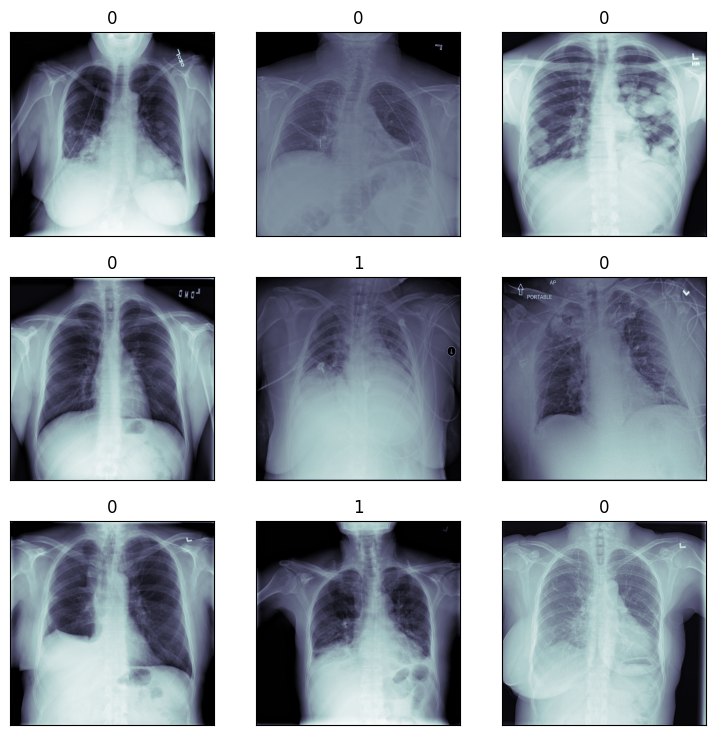

In [ ]:
# visualize some data
fig, axis = plt.subplots(3, 3, figsize=(9,9))

c = 0

for i in range(3):
    for j in range(3):

        # get file name from labels
        patient_id = labels.patientId.iloc[c]

        # create file name path
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix('.dcm')

        # read image
        dcm = pydicom.read_file(dcm_path).pixel_array

        # read label
        label = labels['Target'].iloc[c]

        # visualize
        axis[i][j].imshow(dcm, cmap='bone')
        axis[i][j].set_title(label)
        axis[i][j].set_xticks([])
        axis[i][j].set_yticks([])

        c += 1

In [ ]:
# calculate standart deviation and mean of images for standardization
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):

    # get file name from labels
    patient_id = labels.patientId.iloc[c]

    # create file name path
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')

    # read image
    dcm = pydicom.read_file(dcm_path).pixel_array / 255 # standardization

    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)

    label = labels.Target.iloc[c]

    # images before 24000 th are belongs to training set
    train_or_val = 'train' if c < 24000 else 'val'

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)

    # save it
    np.save(current_save_path/patient_id, dcm_array)

    # calculate sums and sums_square
    normalizer = 224 * 224

    if train_or_val == 'train':
        # validationset must not have any effect on training set
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
drive.flush_and_unmount()